In [1]:
from datetime import datetime

from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.visualization import hist

from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
#%matplotlib widget

In [2]:
YEAR = 2021
rootdir = Path("./data")
# use find to make this csv list
with open(rootdir / f"reanalyze_csvs_{YEAR}.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [3]:
g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
binospec,52882,1,binospec,52882
f5,1472,1,f5,1472
mmirs,19357,1,mmirs,19357
newf9,588,1,newf9,588


In [9]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
fixed = data[np.isfinite(data['seeing'])]
fixed = data[np.isfinite(data['vlt_seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['seeing'] > 0.]
fixed = fixed[fixed['seeing'] < 4.]
#fixed = fixed[fixed['time'] < "2020-12-31"]

In [10]:
fixed.sort_values(by='time')

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,xcen,ycen,seeing,raw_seeing,vlt_seeing,raw_vlt_seeing,ellipticity,fwhm,wavefront_rms,residual_rms
0,2021-01-01T04:28:01,mmirs,mmirs_wfs_0001.fits,30.0,1.0119,137.245521,81.189059,4.55,-3.4,-2.775,...,237.500337,231.997203,1.873983,1.887332,1.648706,1.660450,0.079982,7.101720,3048.778657,3537.084389
1,2021-01-01T04:28:33,mmirs,mmirs_wfs_0002.fits,30.0,1.0117,137.829395,81.262863,4.55,-3.4,-2.796,...,235.499625,232.003211,1.951772,1.965441,1.705144,1.717086,0.059889,7.318841,3058.046576,3555.182049
2,2021-01-01T04:29:05,mmirs,mmirs_wfs_0003.fits,30.0,1.0115,138.502307,81.345507,4.52,-3.4,-2.822,...,242.996312,233.996843,1.848323,1.861047,1.633441,1.644686,0.080403,7.028507,2912.942349,3606.418789
3,2021-01-01T04:29:38,mmirs,mmirs_wfs_0004.fits,30.0,1.0113,139.098079,81.416575,4.52,-3.4,-2.863,...,231.506328,232.005799,1.921168,1.934164,1.654704,1.665898,0.063100,7.231979,856.698259,3642.599303
4,2021-01-01T04:30:10,mmirs,mmirs_wfs_0005.fits,30.0,1.0111,139.788716,81.496548,4.45,-3.4,-2.855,...,233.495050,232.995931,1.948837,1.961788,1.716201,1.727606,0.093292,7.308700,836.552488,3889.541682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2021-12-27T11:08:14,mmirs,mmirs_wfs_0341.fits,30.0,1.6153,78.157208,38.250231,3.70,3.5,3.194,...,264.003272,228.989309,1.495701,1.994329,1.324808,1.766465,0.161785,7.398968,1030.916428,1714.471832
257,2021-12-27T11:08:46,mmirs,mmirs_wfs_0342.fits,30.0,1.6111,78.211357,38.367636,3.73,3.5,3.143,...,266.000847,230.994648,1.460995,1.945011,1.287775,1.714405,0.161000,7.262116,1013.098967,1810.478975
258,2021-12-27T11:09:19,mmirs,mmirs_wfs_0343.fits,30.0,1.6072,78.261589,38.476459,3.70,3.4,3.118,...,264.012393,229.001523,1.532624,2.037406,1.350131,1.794808,0.211274,7.518283,793.853497,1758.870017
259,2021-12-27T11:09:52,mmirs,mmirs_wfs_0344.fits,30.0,1.6032,78.314708,38.591622,3.68,3.4,3.047,...,263.990702,228.997046,1.490464,1.978400,1.314651,1.745031,0.185033,7.354798,886.072646,1709.367483


In [11]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

<Figure size 800x500 with 0 Axes>

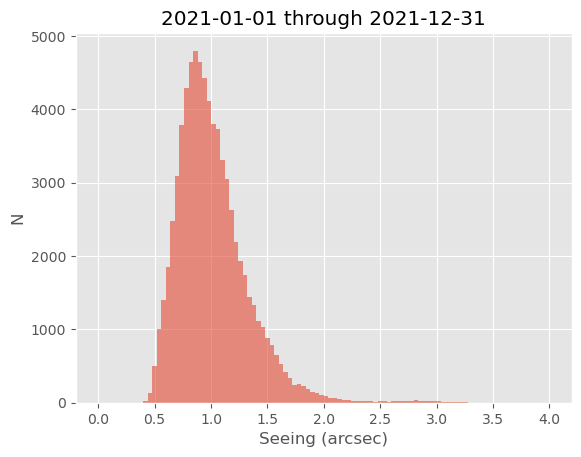

In [12]:
# make raw histogram of the zenith-corrected seeing column
fig = plt.figure(figsize=(8, 5))
fixed.hist(column='vlt_seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
with plt.style.context('ggplot'):
    plt.title(f"{YEAR}-01-01 through {YEAR}-12-31")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
plt.show()

In [13]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(fixed['vlt_seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(fixed['vlt_seeing'])
fit_median = exp_mu + loc

0.38970139417469585 0.2411147693469404 0.7193752422573761


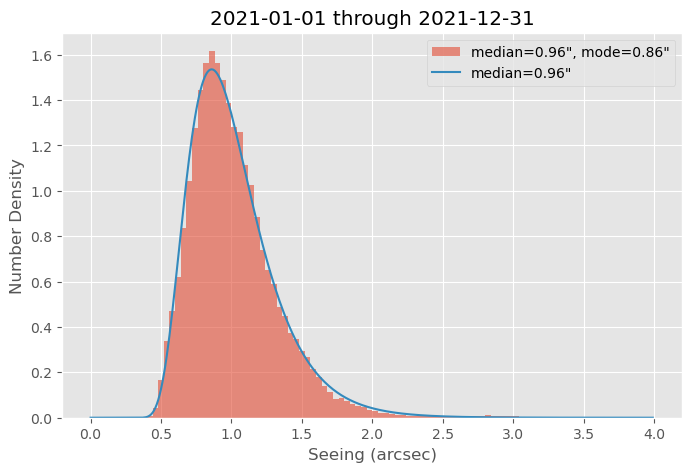

In [14]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(fixed['vlt_seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title(f"{YEAR}-01-01 through {YEAR}-12-31")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig(f"{YEAR}_allyear.png")
plt.show()

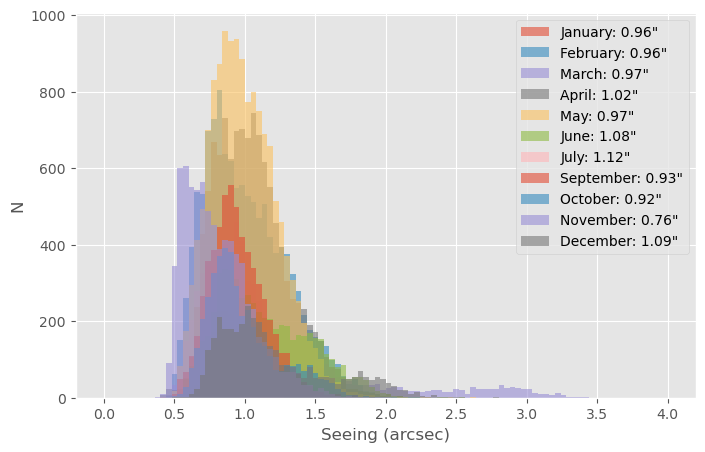

In [16]:
# panda time indexing makes it easy to group by month
fig = plt.figure(figsize=(8, 5))
months = {}
legends = []
months["January"] = fixed.loc[f"{YEAR}-01"]
months["February"] = fixed.loc[f"{YEAR}-02"]
months["March"] = fixed.loc[f"{YEAR}-03"]
months["April"] = fixed.loc[f"{YEAR}-04"]
months["May"] = fixed.loc[f"{YEAR}-05"]
months["June"] = fixed.loc[f"{YEAR}-06"]
months["July"] = fixed.loc[f"{YEAR}-07"]
months["September"] = fixed.loc[f"{YEAR}-09"]
months["October"] = fixed.loc[f"{YEAR}-10"]
months["November"] = fixed.loc[f"{YEAR}-11"]
months["December"] = fixed.loc[f"{YEAR}-12"]
for m in months:
    plt.hist(months[m]["vlt_seeing"], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(months[m]["vlt_seeing"]))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig(f"{YEAR}_monthly.png")
plt.show()

In [17]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['vlt_seeing'])
med_2nd = np.median(second_half['vlt_seeing'])

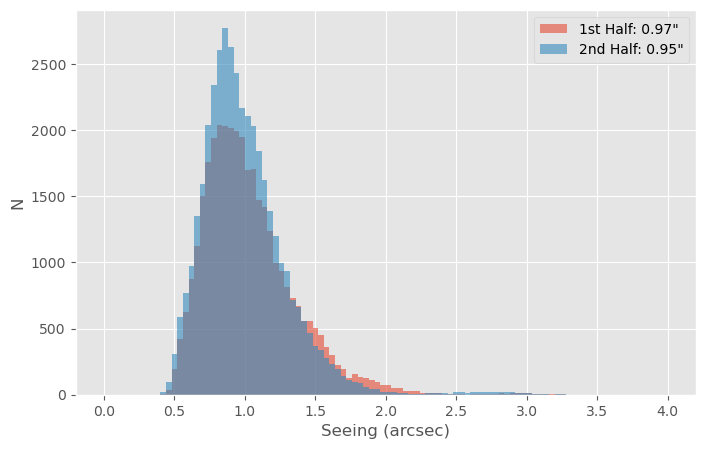

In [18]:
# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['vlt_seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['vlt_seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig(f"{YEAR}_1st2nd.png")
plt.show()

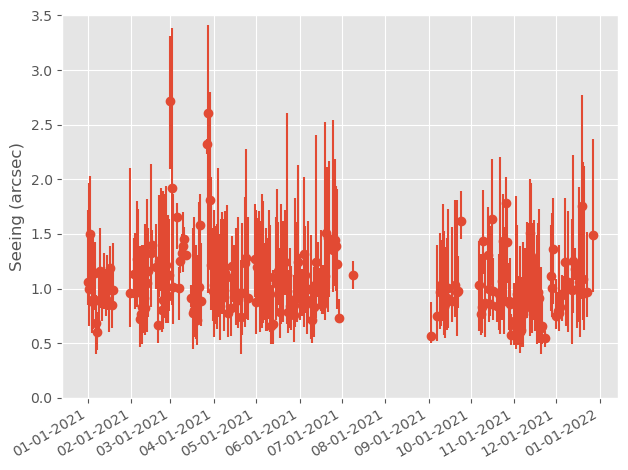

In [19]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = fixed.vlt_seeing.resample('D').median()
daily['max'] = fixed.vlt_seeing.resample('D').max()
daily['min'] = fixed.vlt_seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
ax.set_ylim(0.0, 3.5)
fig.autofmt_xdate()
plt.tight_layout()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig(f"{YEAR}_nightly.png")
plt.show()

In [20]:
date_list = list(daily.index.strftime('%Y-%m-%d'))
data = [np.array(fixed.loc[date]['vlt_seeing']) for date in date_list]
ellipticity_data = [np.array(fixed.loc[date]['ellipticity']) for date in date_list]
clean_data = {}
clean_ellipticity = {}
for d, arr in zip(date_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
for d, arr in zip(date_list, ellipticity_data):
    if len(arr) > 0:
        clean_ellipticity[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m-%d").date() for d in clean_data.keys()]

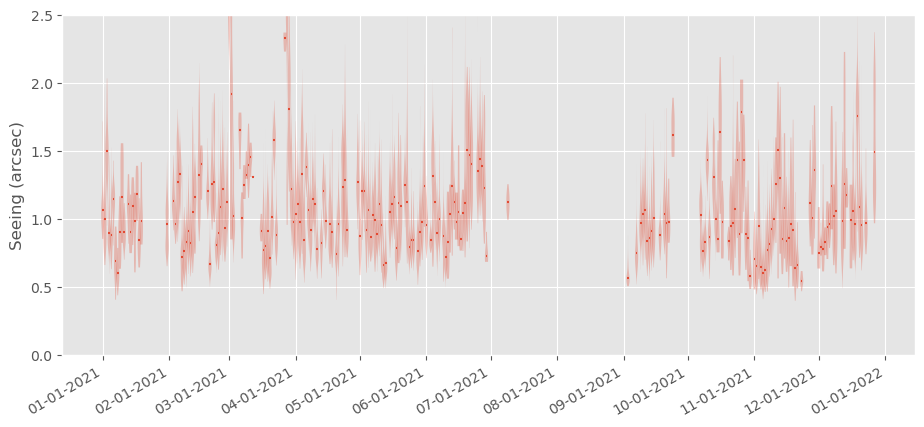

In [21]:
with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    fig.autofmt_xdate()
    ax.set_ylim(0.0, 2.5)
    plt.ylabel("Seeing (arcsec)")
    plt.savefig(f"{YEAR}_violin.png")
    plt.show()

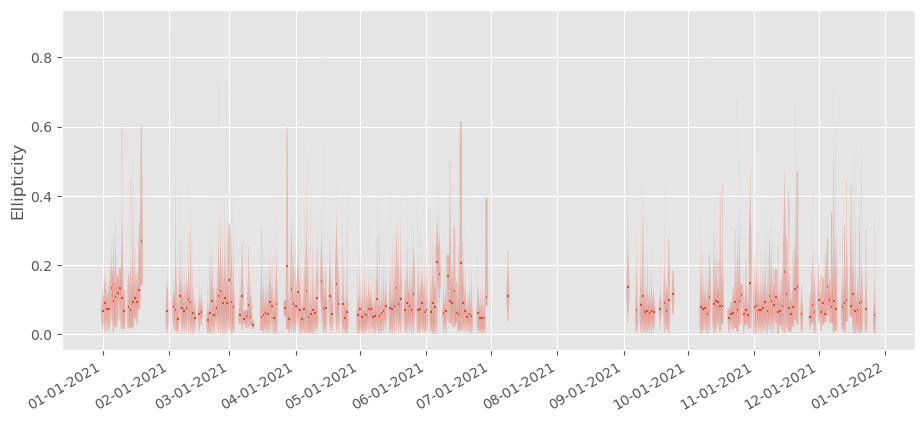

In [22]:
with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_ellipticity.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    fig.autofmt_xdate()
    plt.ylabel("Ellipticity")
    plt.savefig(f"{YEAR}_ellip_violin.png")
    plt.show()

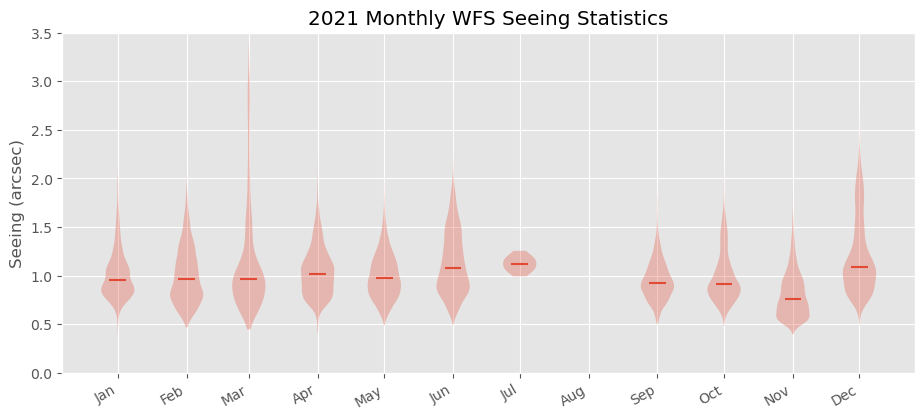

In [23]:
months = sorted(list(set(daily.index.strftime('%Y-%m'))))
mdata = [np.array(fixed.loc[month]['vlt_seeing']) for month in months]
clean_data = {}
for d, arr in zip(months, mdata):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m").date() for d in clean_data.keys()]

with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=100, widths=15,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_ylim(0.0, 3.5)
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig(f"{YEAR}_violin_monthly.png")
    plt.title(f"{YEAR} Monthly WFS Seeing Statistics")
    plt.show()

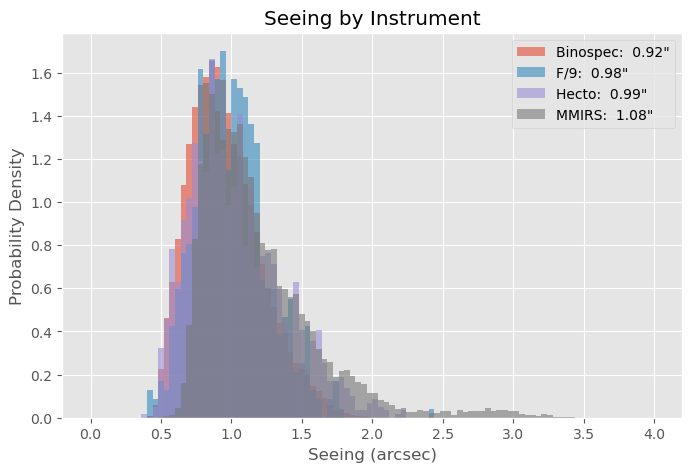

In [24]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    medb = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'binospec'])
    med9 = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'newf9'])
    medf = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'f5'])
    medm = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'mmirs'])
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'binospec'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"Binospec: {medb: .2f}\"")
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'newf9'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"F/9: {med9: .2f}\"")
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'f5'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"Hecto: {medf: .2f}\"")
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'mmirs'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"MMIRS: {medm: .2f}\"")
    plt.legend()
    plt.title("Seeing by Instrument")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Probability Density")
plt.savefig(f"per_instrument_{YEAR}.png")
plt.show()

In [25]:
f9 = fixed[fixed['wfs'] == 'newf9']
bino = fixed[fixed['wfs'] == 'binospec']
hecto = fixed[fixed['wfs'] == 'f5']
mmirs = fixed[fixed['wfs'] == 'mmirs']

In [26]:
f9_dates = sorted(list(set(f9.index.strftime('%Y-%m-%d'))))
bino_dates = sorted(list(set(bino.index.strftime('%Y-%m-%d'))))
hecto_dates = sorted(list(set(hecto.index.strftime('%Y-%m-%d'))))
mmirs_dates = sorted(list(set(mmirs.index.strftime('%Y-%m-%d'))))
bino_dates, hecto_dates, f9_dates, mmirs_dates

(['2021-02-03',
  '2021-02-04',
  '2021-02-05',
  '2021-02-06',
  '2021-02-07',
  '2021-02-08',
  '2021-02-09',
  '2021-02-10',
  '2021-02-11',
  '2021-02-12',
  '2021-02-13',
  '2021-02-15',
  '2021-02-16',
  '2021-02-19',
  '2021-02-20',
  '2021-02-21',
  '2021-02-22',
  '2021-03-17',
  '2021-03-18',
  '2021-03-19',
  '2021-03-20',
  '2021-03-21',
  '2021-03-22',
  '2021-03-23',
  '2021-04-01',
  '2021-04-02',
  '2021-04-03',
  '2021-04-04',
  '2021-04-05',
  '2021-04-06',
  '2021-04-07',
  '2021-04-08',
  '2021-04-09',
  '2021-04-10',
  '2021-04-11',
  '2021-04-13',
  '2021-04-14',
  '2021-04-15',
  '2021-04-17',
  '2021-04-18',
  '2021-04-20',
  '2021-04-21',
  '2021-04-23',
  '2021-04-30',
  '2021-05-01',
  '2021-05-02',
  '2021-05-03',
  '2021-05-04',
  '2021-05-05',
  '2021-05-06',
  '2021-05-07',
  '2021-05-08',
  '2021-05-09',
  '2021-05-10',
  '2021-05-11',
  '2021-05-12',
  '2021-05-13',
  '2021-05-15',
  '2021-05-16',
  '2021-05-17',
  '2021-05-18',
  '2021-05-19',
  '2021-

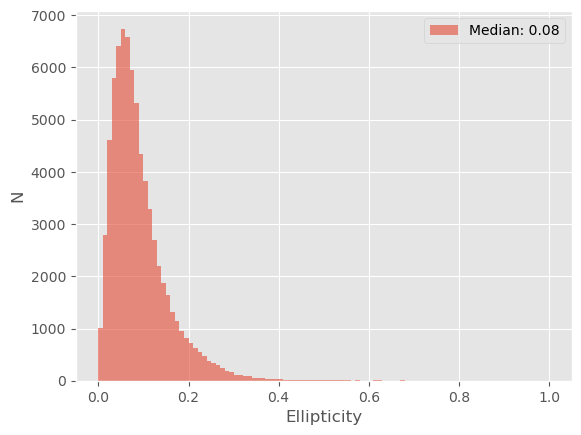

In [27]:
plt.hist(fixed['ellipticity'], bins=100, range=(0.0, 1.0), alpha=0.6, label=f"Median: {np.median(fixed['ellipticity']):.2f}")
plt.xlabel("Ellipticity")
plt.ylabel("N")
plt.legend()
plt.savefig(f"ellipticity_{YEAR}.png")
plt.show()


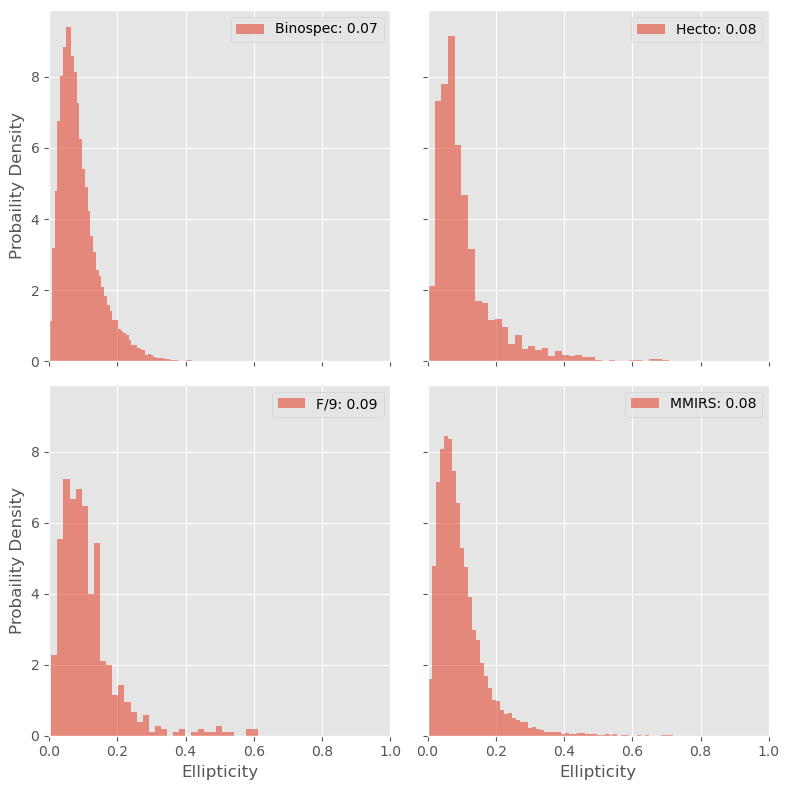

In [28]:
with plt.style.context('ggplot', after_reset=False):
    fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
    ax = ax.flat
    fig.subplots_adjust(hspace=0)

    bin_type = "knuth"

    hist(bino['ellipticity'], bins=bin_type, ax=ax[0], histtype='stepfilled', alpha=0.6, density=True)
    ax[0].legend([f"Binospec: {np.median(bino['ellipticity']):.2f}"])
    ax[0].set_ylabel("Probaility Density")
    ax[0].set_xlim(0, 1)

    hist(hecto['ellipticity'], bins=bin_type, ax=ax[1], histtype='stepfilled', alpha=0.6, density=True)
    ax[1].legend([f"Hecto: {np.median(hecto['ellipticity']):.2f}"])
    ax[1].set_xlim(0, 1)

    hist(f9['ellipticity'], bins=bin_type, ax=ax[2], histtype='stepfilled', alpha=0.6, density=True)
    ax[2].legend([f"F/9: {np.median(f9['ellipticity']):.2f}"])
    ax[2].set_xlim(0, 1)
    ax[2].set_xlabel("Ellipticity")
    ax[2].set_ylabel("Probaility Density")

    hist(mmirs['ellipticity'], bins=bin_type, ax=ax[3], histtype='stepfilled', alpha=0.6, density=True)
    ax[3].legend([f"MMIRS: {np.median(mmirs['ellipticity']):.2f}"])
    ax[3].set_xlim(0, 1)
    ax[3].set_xlabel("Ellipticity")

    plt.tight_layout()
    plt.savefig(f"{YEAR}_ellip_vs_inst.png")
    plt.show()